# Structural Estimation HW2 
## Takuya Ando 

## Question1

(a)First, load necessary packages.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts
import math
import scipy.special as spc
from sympy import Symbol,solve,exp
from scipy import integrate

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Load data.

In [80]:
clms = pd.read_csv("clms.txt", header=None)
clms.columns = ["health_expenditure"]
clms = clms.health_expenditure

Mean, median, max and minimum values are as below.

In [81]:
print("mean: ", np.mean(clms))

mean:  720.2779753272437


In [82]:
print("median: ", np.median(clms))

median:  172.21


In [83]:
print("max: ", np.max(clms))

max:  227967.25


In [84]:
print("min: ", np.min(clms))

min:  0.01


The histogram for uncensored data is as below. Because of the outliers, the plot seems hard to read.

Text(0, 0.5, 'Frequency of observations')

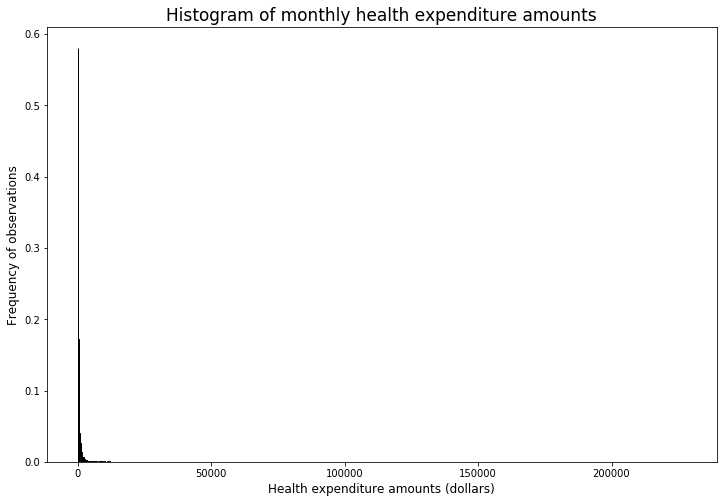

In [85]:
plt.figure(figsize=(12, 8))

weights = (1 / clms.shape[0]) * np.ones_like(clms)

plt.hist(clms, bins=1000, weights=weights, edgecolor="k")
plt.title('Histogram of monthly health expenditure amounts', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Frequency of observations', fontsize=12)

Then, we limit the data under 800 dollars.

In [86]:
clms_bl800 = clms[clms<=800]

Below is the histogram for the data which has only amounts below 800 dolloars. We prefer the second histgram, because there are some outliers in the data considering the max value is enormous value compared to median and mean value, and they make the first histgram seriously hard to interpret. After eliminating such outliers, the second histgram makes much sense than first one.

Text(0, 0.5, 'Frequency of observations')

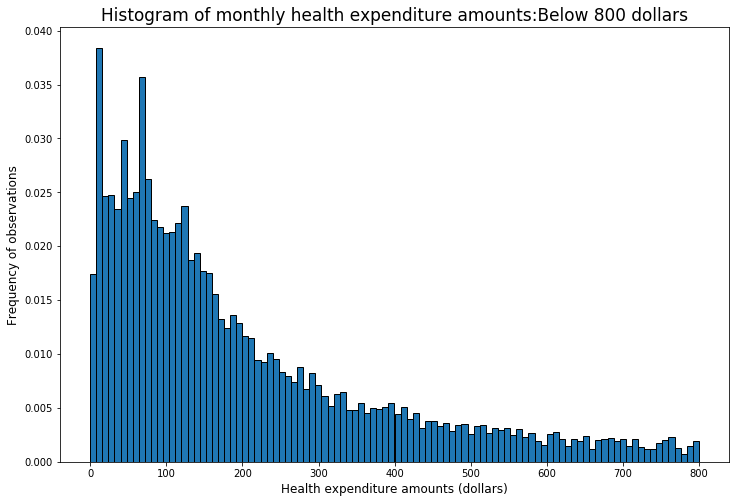

In [87]:
plt.figure(figsize=(12, 8))

weights800 = (1 / clms.shape[0]) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=100, weights=weights800, edgecolor = "k")

plt.title('Histogram of monthly health expenditure amounts:Below 800 dollars', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Frequency of observations', fontsize=12)

(b)First, we define the probability density function for gamma distribution. It computes the probability density for each value in monthly health expenditure. Then, we also define log likelihood function and criteria function(negative version of log likelihood function.)

In [88]:
def gamma_dist(xvals, alpha, beta):
    '''
    Compute the probability density of gamma ditribution for data xvals
    given parameters alpha and beta.
    '''
    pdf_vals = ((1 / ((beta ** alpha) * spc.gamma(alpha))) *
                (xvals ** (alpha - 1)) * (np.exp(-xvals/beta)))
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

# Define log likelihood function for the gamma distribution
def log_lik_gamma(xvals, alpha, beta):
    '''
    Compute the log likelihood function for data xvals given gamma
    distribution parameters alpha and beta.
    '''
    pdf_vals = gamma_dist(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):
    '''-
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    '''
    alpha, beta = params
    xvals = args[0]
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha and beta, as well as the maximized log likelihood value are as below.

In [89]:
# Set initial beta and alpha
init_beta = np.var(clms)/np.median(clms)

init_alpha = np.median(clms)/init_beta

params_init = np.array([init_alpha, init_beta])
mle_args = clms
results_uncstr = opt.minimize(crit, params_init, args=mle_args,method='TNC',\
                              bounds=((1e-10, None), (1e-10, None)), tol=1e-12)
alpha_MLE, beta_MLE = results_uncstr.x

print('alpha_MLE=', alpha_MLE, 'beta_MLE=', beta_MLE)
print("Maximized log likelihood: ", log_lik_gamma(clms, alpha_MLE, beta_MLE))

alpha_MLE= 0.5570983475027388 beta_MLE= 998.2798493133596
Maximized log likelihood:  -77001.36875604634


The implied histogram from gamma distribution derived from estimated parameters is the red line in the plot below. Note that we convert original histrogram with the density scale, as we want to compare the density of distribution. Here we can see that our estimated gamma distribution does not reflect the actual data especially in the lower value range.

(0, 0.006)

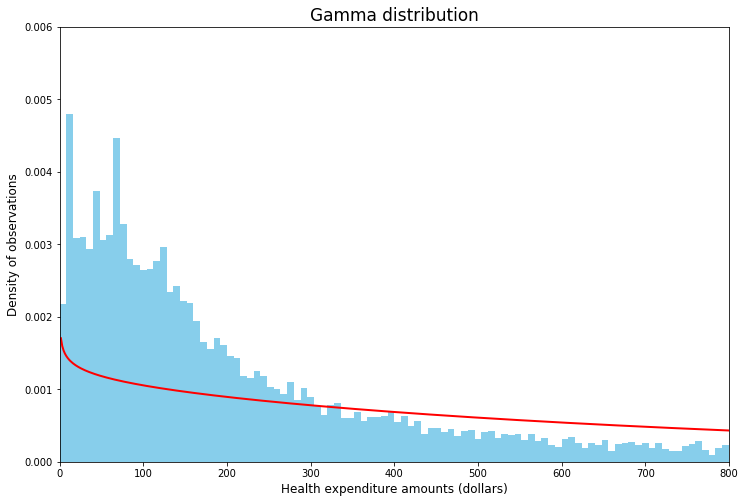

In [110]:
#Plot histgram
plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, color="skyblue")

plt.title('Gamma distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)

# Plot smooth line with distribution 1
dist_pts = np.linspace(0, 800, 500)
alpha_1 = alpha_MLE
beta_1 = beta_MLE
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_1, beta_1),
         linewidth=2, color='r')
plt.xlim([0, 800])
plt.ylim([0, 0.006])

(c)Similary, we define the probability density function for generalized gamma distribution, as well as the log likelihood function and criteria function(negative version of log likelihood function.)

In [91]:
def gengamma_dist(xvals, alpha, beta, m):
    '''
    Compute the probability density of generalized gamma ditribution for data xvals
    given parameters alpha, beta and m.
    '''
    pdf_vals = (m / ((beta**alpha)*spc.gamma(alpha/m))) *(xvals**(alpha-1))* np.exp(-(xvals/beta)**m)

    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

def log_lik_gengamma(xvals, alpha, beta, m):
    '''
    Compute the log likelihood function for data xvals given generalized
    gamma distribution parameters alpa, beta and m.
    '''
    pdf_vals = gengamma_dist(xvals, alpha, beta,m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):
    '''
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    '''
    alpha, beta, m = params
    xvals = args[0]
    log_lik_val = log_lik_gengamma(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha, beta and m, as well as the maximized log likelihood value are as below. The maxlimized log likelihood improves somewhat.

In [92]:
# Set initial beta and alpha
init_alpha = alpha_MLE

init_beta = beta_MLE

init_m = 1

params_init = np.array([init_alpha, init_beta, init_m])
mle_args = clms
results_uncstr = opt.minimize(crit, params_init, args=mle_args, \
                              method='SLSQP', bounds=((1e-10, None),\
                                                         (1e-10, None), (1e-10, None)), tol=1e-12)
genalpha_MLE, genbeta_MLE, m = results_uncstr.x
print('genalpha_MLE=', genalpha_MLE, ' genbeta_MLE=', genbeta_MLE, "m_MLE=", m)
print("Maximized log lilelihood: ", log_lik_gengamma(clms, genalpha_MLE, genbeta_MLE, m))

genalpha_MLE= 1.9603259087758753  genbeta_MLE= 0.017069959929058257 m_MLE= 0.22609206483361005
Maximized log lilelihood:  -75061.41510941926


The implied histogram from gamma distribution derived from estimated parameters is the yellow line in the plot below. It seems generalized gamma distribution fit the data in lower values better than gamma distribution.

(0, 0.006)

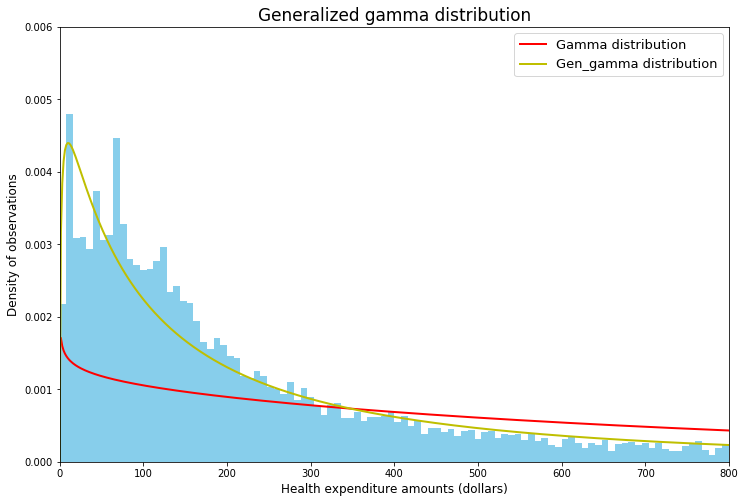

In [111]:
#Plot histgram
plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, color="skyblue")

plt.title('Gamma distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)

# Plot smooth line with distribution 1
dist_pts = np.linspace(0, 800, 500)
alpha_1 = alpha_MLE
beta_1 = beta_MLE
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_1, beta_1),
         linewidth=2, color='r', label='Gamma distribution')

plt.title('Generalized gamma distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)
plt.legend(loc='upper right', fontsize=13)

gen_alpha = genalpha_MLE
gen_beta = genbeta_MLE
gen_m = m
plt.plot(dist_pts, gengamma_dist(dist_pts, gen_alpha, gen_beta, gen_m) ,
         linewidth=2, color='y', label='Gen_gamma distribution')
plt.legend(loc='upper right', fontsize=13)

plt.xlim([0, 800])
plt.ylim([0, 0.006])

(d)Similary as in previous questions, we define the probability density function for generalized beta 2 distribution. As generalized gamma distribution is the nested one of GB2, we can define it using alpha, beta and m parameters from generalized gamma distribution. We also define the log likelihood function and criteria function(negative version of log likelihood function.)

In [94]:
def gb2_dist(xvals, alpha, beta, m, q):
    '''
    Compute the probability density of generalized beta2 ditribution for data xvals
    given parameters alpha, beta, m and q.
    '''
    pdf_vals = (m*(xvals**(alpha-1))) / ((((q**(1/m))*beta)**alpha) * \
    spc.beta(alpha/m, q) * ((1+(xvals/((q**(1/m))*beta))**m)**(alpha/m +q))) 
    
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

def log_lik_gb2(xvals, alpha, beta, m, q):
    '''
    Compute the log likelihood function for data xvals given GB2
    distribution parameters alpa, beta, m and q.
    '''
    pdf_vals = gb2_dist(xvals, alpha, beta,m,q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):

    alpha, beta, m,q = params
    xvals = args[0]
    log_lik_val = log_lik_gb2(xvals, alpha, beta, m, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha, beta, m and q, as well as the maximized log likelihood value are as below. We improved maximized log likelihood a little again.

In [95]:
# Set initial beta and alpha
init_alpha = genalpha_MLE

init_beta = genbeta_MLE

init_m = m

init_q = 10000

params_init = np.array([init_alpha, init_beta, init_m, init_q])
mle_args = clms
results_uncstr = opt.minimize(crit, params_init, args=mle_args, method='SLSQP',\
                              bounds=((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None)), tol=1e-12)
gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE = results_uncstr.x
print('gb2alpha_MLE=', gb2alpha_MLE, ' gb2beta_MLE=', gb2beta_MLE, "gb2m_MLE=", gb2m_MLE, "gb2q_MLE=", gb2q_MLE)
print("maximized log likelihood=", log_lik_gb2(clms, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE))

gb2alpha_MLE= 2.7541183354541605  gb2beta_MLE= 6.751075479723694e-06 gb2m_MLE= 0.16339102319175985 gb2q_MLE= 9999.698077967598
maximized log likelihood= -74976.73556253186


The implied histogram from GB2 distribution derived from estimated parameters is the green line in the plot below. As the maximum log likelihood improved slightly, the shape of the distribution also changed from generalized gamma distribution slightly.

(0, 0.006)

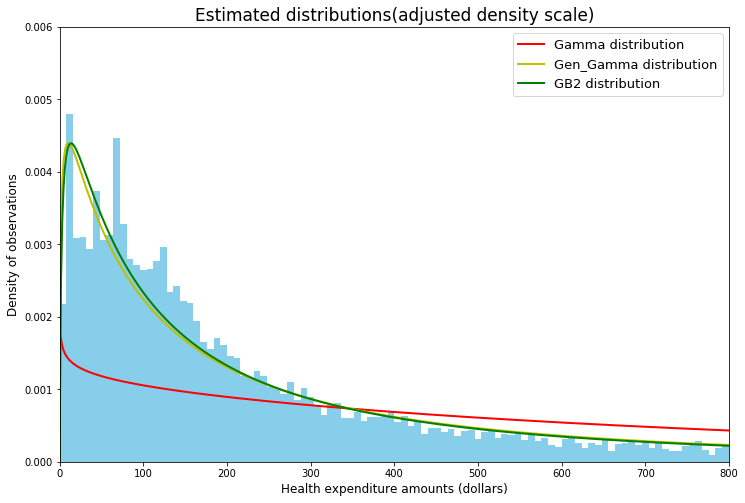

In [107]:
#Plot histgram
plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, color="skyblue")

plt.title('Estimated distributions(adjusted density scale)', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)

# Plot smooth line with distribution 1
dist_pts = np.linspace(0, 800, 500)
alpha_1 = alpha_MLE
beta_1 = beta_MLE
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_1, beta_1),
         linewidth=2, color='r', label='Gamma distribution')
plt.legend(loc='upper right')

gen_alpha = genalpha_MLE
gen_beta = genbeta_MLE
gen_m = m
plt.plot(dist_pts, gengamma_dist(dist_pts, gen_alpha, gen_beta, gen_m) ,
         linewidth=2, color='y', label='Gen_Gamma distribution')
plt.legend(loc='upper right')

gb2_alpha = gb2alpha_MLE
gb2_beta = gb2beta_MLE
gb2_m = gb2m_MLE
gb2_q = gb2q_MLE
plt.plot(dist_pts, gb2_dist(dist_pts, gb2_alpha, gb2_beta, gb2_m, gb2_q) ,
         linewidth=2, color='g', label='GB2 distribution')
plt.legend(loc='upper right', fontsize=13)
plt.xlim([0, 800])
plt.ylim([0, 0.006])

(e)The two code chunks below are performing log likelihood ratio test for gamma dirtibution and generalized gamma distribution estimates against GB2 estimates, that is, the null hypothesis is that true parameters are ones estimated from Gamma or Generalized gamma. The results below show that p-values for chi-squared distribution of log_likelihood ratio tests are almost zero for both. Thus, we reject the null for both cases.

In [97]:
##Likelihood ratio test for gamma distribution against GB2

log_lik_h0 = log_lik_gamma(clms, alpha_MLE, beta_MLE)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_gb2(clms, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -77001.36875604634
MLE log likelihood -74976.73556253186
likelihood ratio value 4049.266387028969
chi squared of H0 with 4 degrees of freedom p-value =  0.0


In [98]:
##Likelihood ratio test for generalized gamma distribution against GB2

log_lik_h0 = log_lik_gengamma(clms, genalpha_MLE, genbeta_MLE, gen_m)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_gb2(clms, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -75061.41510941926
MLE log likelihood -74976.73556253186
likelihood ratio value 169.35909377480857
chi squared of H0 with 4 degrees of freedom p-value =  0.0


(f)In order to have the probability that we have more than 1000 dollars health expenditure, we want the probability  density of the GB2 distribution using estimated parameters by MLE. Then we can integrate the pdf to have cdf at x = 1000 and deduct it from 1 so that we have the probability of having expenditure larger than 1000 dollars. Thus, the probability is about 12.5 % here.

In [99]:
# Define pdf function

def compute_prob(xvals):
    '''
    Compute probability density for each value using estimated parameters for GB2
    '''
    return (gb2m_MLE*(xvals**(gb2alpha_MLE-1))) /\
((((gb2q_MLE**(1/gb2m_MLE))*gb2beta_MLE)**gb2alpha_MLE) * \
    spc.beta(gb2alpha_MLE/gb2m_MLE, gb2q_MLE) * \
 ((1+(xvals/((gb2q_MLE**(1/gb2m_MLE))*gb2beta_MLE))**gb2m_MLE)**(gb2alpha_MLE/gb2m_MLE +gb2q_MLE)))

# Integrate pdf to acquire probability of xvals<=1000 and deduct it from 1
1- integrate.quad(compute_prob, 0, 1000)[0]

0.1259037490703706

## Question2

(a)Load data.

In [100]:
macro = pd.read_csv("MacroSeries.txt", header=None)
macro.columns = ["c_t", "k_t", "w_t", "r_t"]
macro.head()

,c_t,k_t,w_t,r_t
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


First, using equation(3), we can derive $z_t$ as below.


$$ w_t-(1-\alpha)e^{z_t}k_{t}^\alpha = 0 \\ e^{z_t} = \frac{w_t}{(1-\alpha)k_{t}^\alpha} \\ z_t = ln(\frac{w_t}{(1-\alpha)k_{t}^\alpha})  $$

Then, we define pdf function for $z_t$. We can derive the distribution of $z_t$ using equation(5).

In [101]:
def norm_dist(k, w, alpha, mu, sigma, p):
    '''
    Calculate pdf values of z_t using equation(3) and (5)
    '''
    # Derive z_t values using equation(3)
    z_t = np.log(w/((1-alpha)*k**alpha))
    
    z_vec = np.empty(101)
    
    # z_0 = mu
    z_vec[0] = mu
    
    # Derive probability distribution of z using equation(4)
    for i in range(1, len(z_vec)):
        z_vec[i] = sts.norm.pdf(z_t[i-1], p*z_vec[i-1]+(1-p)*mu, sigma)
    
    # We want probability of z only in t=1:100
    pdf_vals = z_vec[1:100]
    
    return pdf_vals

Then, we define log_likelihood function and criteria function similary as in the precvious question.

In [102]:
def log_lik_norm(k, w, alpha, mu, sigma, p):
    
    pdf_vals = norm_dist(k, w, alpha, mu, sigma, p)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

def crit(params, *args):
    
    alpha, mu, sigma, p = params
    k, w = args
    log_lik_val = log_lik_norm(k, w, alpha, mu, sigma, p)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Now we perform MLE estimation. We set initial $alpha$ and $p$ as the center of their constraint and $mu$. Also, we set initial $mu$ and $sigma$ from the series of z_t derived from initial alpha. The estimated parameters, maximum log likelihood and hessian variance-covariance matrix of estmates are as below.

In [103]:
# Define k and w
k = macro.k_t
w = macro.w_t

# Set initial parameters

init_alpha = 0.5

# Derive z
z = np.log(w/((1-init_alpha)*k**init_alpha))

init_mu = np.mean(z)

init_sigma = np.sqrt(np.var(z))

init_p = 0

params_init = np.array([init_alpha, init_mu, init_sigma, init_p])
mle_args = (k, w)
results_uncstr = opt.minimize(crit, params_init,
                              args=(mle_args), method='L-BFGS-B', 
                              bounds=((1e-10, 1), (1e-10, None), (1e-10, None), (-1+1e-10, 1-1e-10)))
alpha_MLE, mu_MLE, sigma_MLE, p_MLE = results_uncstr.x
print('alpha_MLE=', alpha_MLE, ' mu_MLE=', mu_MLE, "sigma_MLE=", sigma_MLE, "p_MLE=", p_MLE)
print("maximized log likelihood=", log_lik_norm(k, w, alpha_MLE, mu_MLE, sigma_MLE, p_MLE))
print("Hessian variance-covariance matrix of estimates: ")
print(results_uncstr.hess_inv.todense())

alpha_MLE= 0.9076898030937728  mu_MLE= 4.196957098427336 sigma_MLE= 0.0959431313366477 p_MLE= 0.014709857270202516
maximized log likelihood= 90.6598170812713
Hessian variance-covariance matrix of estimates: 
[[ 0.89092335 -3.97921524 -0.45090456  0.60029072]
 [-3.97921524 19.20713032  1.49243328 -1.80917009]
 [-0.45090456  1.49243328  0.41803043 -0.62095122]
 [ 0.60029072 -1.80917009 -0.62095122  0.93466339]]


(b) Similary as in (a), we can derive $z_t$ using equation(4) as below.

$$ r_t-\alpha e^{z_t}k_{t}^{\alpha-1} = 0 \\ e^{z_t} = \frac{r_t}{\alpha k_{t}^{\alpha-1}} \\ z_t = ln(\frac{r_t}{\alpha k_{t}^{\alpha-1}})  $$

Then, we define pdf function for $z_t$. We can derive the distribution of $z_t$ using equation(5). We also define log likelihood function as well as criteria function.

In [104]:
def norm_dist2(k, r, alpha, mu, sigma, p):
    '''
    Calculate pdf values of z_t using equation(4) and (5)
    '''
    # Derive z_t values using equation(4)
    z_t = np.log(r/(alpha*(k**(alpha-1))))
    
    z_vec = np.empty(101)
    
    # z_0 = mu
    z_vec[0] = mu
    
    # Derive probability distribution of z using equation(4)
    for i in range(1, len(z_vec)):
        z_vec[i] = sts.norm.pdf(z_t[i-1], p*z_vec[i-1]+(1-p)*mu, sigma)
    
    # We want probability of z only in t=1:100
    pdf_vals = z_vec[1:100]
    return pdf_vals

def log_lik_norm2(k, r, alpha, mu, sigma, p):
   
    pdf_vals = norm_dist2(k, r, alpha, mu, sigma, p)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

def crit(params, *args):
    
    alpha, mu, sigma, p = params
    k, r = args
    log_lik_val = log_lik_norm2(k, r, alpha, mu, sigma, p)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Again we perform MLE estimation similary as in the previous question. The estimated parameters, maximum log likelihood and hessian variance-covariance matrix of estmates are as below.

In [105]:
# Define k,r
k = macro.k_t
r = macro.r_t

# Set initial parameters
init_alpha = 0.5

z = np.log(r/(init_alpha*(k**(init_alpha-1))))

init_mu = np.mean(z)

init_sigma = np.sqrt(np.var(z))

init_p = 0

params_init = np.array([init_alpha, init_mu, init_sigma, init_p])
mle_args = (k, r)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B', bounds=((1e-10, 1), (1e-10, None), (1e-10, None), (-1+1e-10, 1-1e-10)))
alpha2_MLE, mu2_MLE, sigma2_MLE, p2_MLE = results_uncstr.x
print('alpha2_MLE=', alpha2_MLE, ' mu2_MLE=', mu2_MLE, "sigma2_MLE=", sigma2_MLE, "p2_MLE=", p2_MLE)
print("maximized log likelihood=", log_lik_norm2(k, r, alpha2_MLE, mu2_MLE, sigma2_MLE, p2_MLE))
print("Hessian variance-covariance matrix of estimates: ")
print(results_uncstr.hess_inv.todense())

alpha2_MLE= 0.9726146367022261  mu2_MLE= 0.46621562338170114 sigma2_MLE= 0.11768009311755566 p2_MLE= -0.0008032831088494409
maximized log likelihood= 85.14868411309952
Hessian variance-covariance matrix of estimates: 
[[ 3.00663614e+03 -4.34436742e+04 -6.92621247e+01  1.13810077e+03]
 [-4.34436742e+04  6.27729523e+05  1.00062232e+03 -1.64446257e+04]
 [-6.92621247e+01  1.00062232e+03  1.65619634e+00 -2.62494710e+01]
 [ 1.13810077e+03 -1.64446257e+04 -2.62494710e+01  4.30822128e+02]]


(c)First, using equation(4), we acquire z_st. Then, as z is distributed normally with mean of 10*p+(1-p)*mu +e and sigma as sigma_MLE, we can calculate the probability that z becomes equal or smaller than z_st using cdf of z. Then, the probability that r_t becomes larger than 1 is calculated as below and it is almost 100 %.

In [106]:
z = np.log(r/(init_alpha*(k**(init_alpha-1))))

z_st = np.log(1/(alpha_MLE*(7500000)**(alpha_MLE-1)))

mu = 10*p_MLE+(1-p_MLE)*mu_MLE

# Deduct the probability that z<=z_st from 1
1 - sts.norm.cdf(z_st, loc=mu, scale=sigma_MLE)

1.0